# Apply Summary Statistic to whole data
Goal here: 
1. Develop Summary Statistic to identify offspring of first cousins or closer
2. Apply to groups of ancient & modern Individuals

In [127]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from statsmodels.stats.proportion import proportion_confint  # Estimate Binomial proportion Confidence Intervalls

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Helper Functions

In [125]:
# frac = 0.65    # The fraction of the short ROH substraction
# min_stat = 0.8 # The Minimum Stat
def calc_statistic(df, frac=0.65, cm = [4,8,12] ):
    """Calculate the statistic from cutoff.
    cm: Cutoffs [in centiMorgan]
    frac: Fraction of the lower category to substract"""
    statistic = df[f"sum_roh>{cm[2]}"] - frac * ((df[f"sum_roh>{cm[0]}"]) - df[f"sum_roh>{cm[1]}"])
    return statistic

def plot_statistic_hist(statistic, cut_off=70, bins=np.arange(-400,400,5),
                   figsize=(8,4), xlim=[-400,400]):
    """Plot histogram of Statistic"""
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.hist(statistic, bins=bins, ec="k")
    ax.set_xlim(xlim)
    ax.set_ylim([0,200])
    ax.set_title("Distribution Summary Statistic")
    ax.axvline(x=cut_off, color="red")
    plt.show()
    
def print_statistic(statistic, cutoff=[70,100,150,200]):
    """Print # Values of statistic bigger than cutoff"""
    n = len(statistic)
    for c in cutoff:
        n1 = np.sum(statistic>c)
        print(f"Bigger than {c}: {n1}/{n}")
        
def estimate_ci_fractions(df, col_c="sum", col_n="count", method="wilson"):
    """Estimate Confidence Intervals from Binomial Fractions.
    Add these fractions as two new columns to data frame
    (frac_low, frac_high) and return dataframe
    df: Dataframe to use
    col_c: Count Column
    col_n Total Count Column
    method: Which binomial proportion confidence interval to use"""
    c, n = df[col_c].values, df[col_n].values
    low, high = proportion_confint(c,n,method=method)
    df["frac_low"], df["frac_high"] = low, high
    return df

def plot_bars_fractions(df, col="percent", col_l="frac_low", col_h="frac_high", 
                        figsize=(18,5), bar_width=0.9, fs_l=7, ec="k", c="coral", legend=True):
    """Plot Fractions in dataframe df. 
    col: Which column has values
    col_l, col_h: Values for low & high CIs"""

    x = np.arange(len(df_t))
    y = df[col].values

    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.bar(x, y, width = bar_width, color = c, edgecolor = ec)
    # yerr=[df_t["frac_low"], df_t["frac_high"]]

    # general layout
    ax.set_xticks(x)
    ax.set_xticklabels(df_t.index.values, rotation=90, fontsize=fs_l)
    ax.set_xlim([-0.5,len(df_t)])
    ax.set_ylim([0,1])
    ax.set_ylabel("Fraction Individuals with Statistic > 70")
    ax.vlines(x, df[col_l], df[col_h], lw=0.5, label="95% CI Intervalls")
    if legend:
        ax.legend(loc="upper right")
    plt.show()

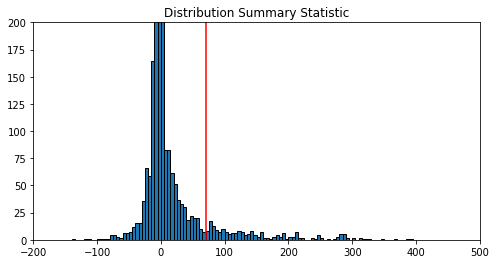

Bigger than 70: 216/3232
Bigger than 100: 152/3232
Bigger than 150: 92/3232
Bigger than 200: 60/3232


In [69]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
statistic = calc_statistic(df)
plot_statistic_hist(statistic, xlim=[-200,500], cut_off=70)
print_statistic(statistic)

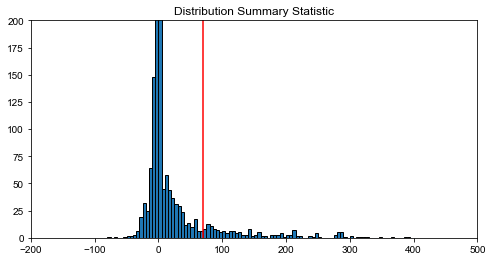

Bigger than 70: 179/1941
Bigger than 100: 127/1941
Bigger than 150: 80/1941
Bigger than 200: 54/1941


In [128]:
df_m = df[df["age"]==0].copy()
statistic = calc_statistic(df_m)
plot_statistic_hist(statistic, cut_off=70, xlim=[-200,500])
print_statistic(statistic)

## Rank Individuals by statistic

In [ ]:
statistic = calc_statistic(df)
idx = np.argsort(statistic)
df.iloc[idx,:]

In [ ]:
### Calculate for Modern Samples
df_m = df[df["age"]==0].copy()
statistic = calc_statistic(df_m)
idx = np.argsort(statistic)
df_m.iloc[idx,:]

### Calculate Statistic per Population

In [202]:
cutoff= 70
min_count = 5 # Minimal Count per Population

df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
statistic = calc_statistic(df)
df["statistic"] = statistic
df[f"statistic>{cutoff}"] = (statistic >= cutoff)

df_m = df[df["age"]==0].copy()
df_mg = df_m.groupby("pop")
df_pop_stat = df_mg[f"statistic>{cutoff}"].agg(["sum", 'count'])
df_pop_stat["percent"] = df_pop_stat["sum"]/df_pop_stat["count"]

df_t = df_pop_stat.sort_values(by="percent", ascending=False)
df_t = estimate_ci_fractions(df_t, col_c="sum", col_n="count", method="wilson")

In [203]:
df_t

,sum,count,percent,frac_low,frac_high
pop,,,,,
Saami_WGA,1.0,1,1.000000,2.065493e-01,1.000000
Surui,8.0,8,1.000000,6.755924e-01,1.000000
Karitiana,9.0,12,0.750000,4.676947e-01,0.911058
Syrian,5.0,8,0.625000,3.057424e-01,0.863156
Balochi,11.0,20,0.550000,3.420853e-01,0.741802
Makrani,10.0,20,0.500000,2.992980e-01,0.700702
BedouinA,11.0,25,0.440000,2.666564e-01,0.629327
Tunisian_Jew,3.0,7,0.428571,1.582199e-01,0.749542
Pima,6.0,14,0.428571,2.138080e-01,0.674094


In [ ]:
df_t.head(10)

### Plot Fraction Bars with Confidence Intervalls for Populations

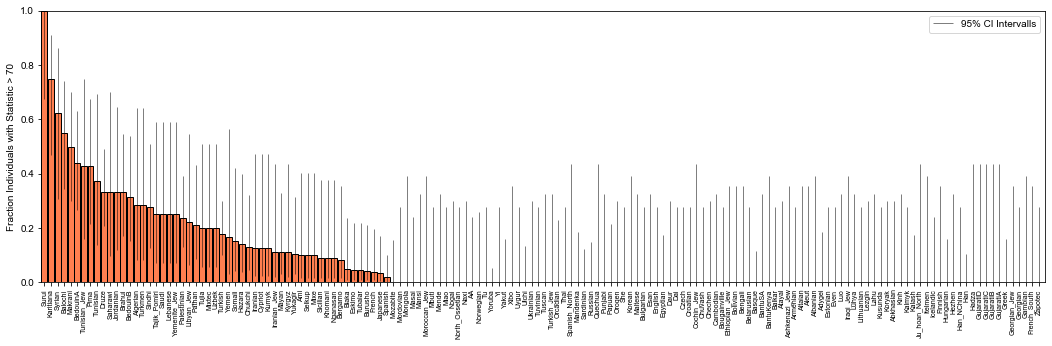

In [204]:
df_t = df_t[df_t["count"]>=min_count]
plot_bars_fractions(df_t)

### Extract Ancient Data

In [215]:
cutoff= 70

df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
statistic = calc_statistic(df)
df["statistic"] = statistic
df[f"statistic>{cutoff}"] = (statistic >= cutoff)

df_a = df[df["age"]>0].copy()
df_meso = df_a[df_a["clst"]=="Mesolithic"].copy()
df_ag = df_meso.groupby("region")
df_pop_stat = df_ag[f"statistic>{cutoff}"].agg(["sum", 'count']).astype("int")
df_pop_stat["percent"] = df_pop_stat["sum"]/df_pop_stat["count"]

df_t = df_pop_stat.sort_values(by="percent", ascending=False)
df_t = estimate_ci_fractions(df_t, col_c="sum", col_n="count", method="wilson")

In [182]:
df_t

,sum,count,percent,frac_low,frac_high
region,,,,,
Rome,1,3,0.333333,0.061492,0.792340
Central Europe,1,4,0.250000,0.045587,0.699358
North Africa,1,4,0.250000,0.045587,0.699358
Iberia,1,7,0.142857,0.025680,0.513128
Balkans,1,37,0.027027,0.004787,0.138241
Andean,0,1,0.000000,0.000000,0.793451
Baltic Sea,0,26,0.000000,0.000000,0.128729
Black Sea,0,4,0.000000,0.000000,0.489891
Pacific NW,0,2,0.000000,0.000000,0.657620


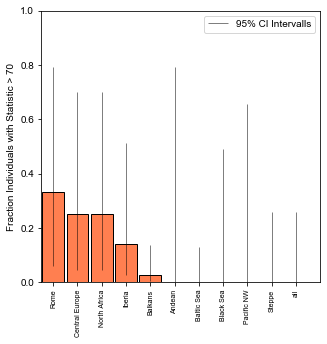

In [216]:
plot_bars_fractions(df_t, figsize=(5,5))

In [187]:
df_t = df_a[(df_a["clst"]=="Mesolithic") & (df_a["region"]=="Balkans")].copy()

In [192]:
df_t = df_a[(df_a["region"]=="Pacific NW")].copy()

In [193]:
df_t

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,lat,...,age,study,clst,mean_cov,n_cov_snp,include_alt,color,region,statistic,statistic>70
131,SN-44.SG,E_San_Nicolas.SG,66.042196,792.091549,73,562.336516,31,463.570596,21,33.264278,...,5337.0,ScheibScience2018,E_San_Nicolas.SG,3.097140,1111229,1,silver,Pacific NW,314.229825,True
133,SN-13.SG,L_San_Nicolas.SG,59.943003,494.892271,41,381.758955,20,336.693565,15,33.264278,...,811.0,ScheibScience2018,L_San_Nicolas.SG,0.580568,509837,1,silver,Pacific NW,263.156910,True
142,SN-11.SG,L_San_Nicolas.SG,36.899203,358.258219,37,230.439425,14,169.441214,8,33.264278,...,1100.0,ScheibScience2018,L_San_Nicolas.SG,1.850441,975879,1,silver,Pacific NW,86.358998,True
148,Anzick_realigned.SG,USA_Anzick_realigned.SG,15.401101,302.329603,41,160.474503,15,53.022099,4,45.993056,...,12649.0,RasmussenNature2014,Mesolithic,14.045536,1169065,1,purple,Pacific NW,-39.183716,False
176,Lovelock4.SG,USA_Nevada_LovelockCave_1850BP.SG,14.604592,214.599305,35,68.356282,6,39.457488,3,39.960000,...,1785.0,MorenoMayarScience2018,USA_Nevada_LovelockCave_1850BP.SG,0.527598,489663,1,silver,Pacific NW,-55.600477,False
189,19651.SG,Canada_BigBar_5700BP.SG,17.811894,169.989804,23,89.717498,8,30.969095,2,51.300000,...,5669.0,MorenoMayarScience2018,Canada_BigBar_5700BP.SG,1.135977,786648,1,silver,Pacific NW,-21.207904,False
192,CT-01.SG,LSCI.SG,10.993397,162.089184,26,47.735390,5,0.000000,0,33.383333,...,414.0,ScheibScience2018,LSCI.SG,2.806377,1085390,1,silver,Pacific NW,-74.329966,False
203,AHUR_2064.SG,USA_Nevada_SpiritCave_11000BP.SG,14.925504,144.004594,25,23.061604,2,14.925504,1,37.410000,...,10970.0,MorenoMayarScience2018,Mesolithic,17.937478,1181994,1,purple,Pacific NW,-63.687439,False
205,Lovelock2.SG,USA_Nevada_LovelockCave_1850BP.SG,18.530298,140.464498,19,63.424200,5,31.748093,2,39.960000,...,1880.0,MorenoMayarScience2018,USA_Nevada_LovelockCave_1850BP.SG,14.359982,1150497,1,silver,Pacific NW,-18.328101,False
216,SC-05.SG,LSCI.SG,17.743901,134.192722,21,43.596606,3,33.130203,2,32.900000,...,1051.0,ScheibScience2018,LSCI.SG,4.302848,1107916,1,silver,Pacific NW,-25.757272,False


# Area 51

### Screen all ancient Data for outstanding Groups

In [207]:
cutoff=  70
min_count = 5

df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
statistic = calc_statistic(df)
df["statistic"] = statistic
df[f"statistic>{cutoff}"] = (statistic >= cutoff)


df_a = df[df["age"]>0].copy()
df_ag = df_a.groupby(["region", "clst"])
df_pop_stat = df_ag[f"statistic>{cutoff}"].agg(["sum", 'count']).astype("int")
df_pop_stat["percent"] = df_pop_stat["sum"]/df_pop_stat["count"]

df_t = df_pop_stat.sort_values(by="percent", ascending=False)
df_t = estimate_ci_fractions(df_t, col_c="sum", col_n="count", method="wilson")

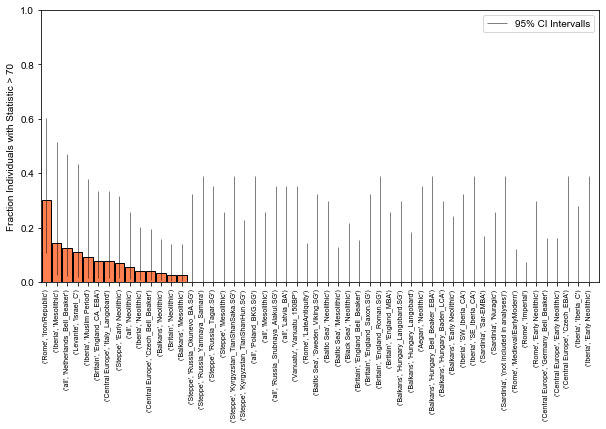

In [213]:
df_t = df_t[df_t["count"]>=min_count]
plot_bars_fractions(df_t, figsize=(10,5))

## Test Binomial Confidence Intervalls

In [49]:
c, n = [0,0,0], [5,50,300]

In [50]:
proportion_confint(c, n)

(array([0., 0., 0.]), array([0., 0., 0.]))

In [51]:
proportion_confint(c,n, method="wilson")

(array([0., 0., 0.]), array([0.43448246, 0.0713476 , 0.01264297]))

In [52]:
proportion_confint(c,n, method="jeffreys")

(array([9.34206000e-05, 9.77166330e-06, 1.63541711e-06]),
 array([0.37937714, 0.04875846, 0.00833127]))

In [124]:
df_t

,sum,count,percent,frac_low,frac_high
pop,,,,,
Saami_WGA,1.0,1,1.000000,2.065493e-01,1.000000
Surui,8.0,8,1.000000,6.755924e-01,1.000000
Karitiana,9.0,12,0.750000,4.676947e-01,0.911058
Syrian,5.0,8,0.625000,3.057424e-01,0.863156
Balochi,11.0,20,0.550000,3.420853e-01,0.741802
Makrani,10.0,20,0.500000,2.992980e-01,0.700702
BedouinA,11.0,25,0.440000,2.666564e-01,0.629327
Tunisian_Jew,3.0,7,0.428571,1.582199e-01,0.749542
Pima,6.0,14,0.428571,2.138080e-01,0.674094
